In [2]:
torch.cuda.empty_cache()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
class CNNblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=stride,bias=False,padding=1,padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.conv(x)
class Discriminator(nn.Module):
    def __init__(self,in_channels = 3, features= [64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2,features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.ReLU(),
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNblock(in_channels,feature,stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(in_channels,1,kernel_size=4,padding=1,padding_mode='reflect',stride=1)
        )
        self.model = nn.Sequential(*layers)
    def forward(self,x,y):
        x = torch.cat([x,y],1)
        x = self.initial(x)
        x = self.model(x)
        return x

def test():
    x = torch.randn((1,3,256,256))
    y = torch.randn((1,3,256,256))
    model = Discriminator()
    out = model(x,y)
    print(out.shape)

test()

torch.Size([1, 1, 30, 30])


In [7]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode='reflect',bias=False)
            if down
            else
            nn.ConvTranspose2d(in_channels,out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.dropout == True else x

class Generator(nn.Module):
    def __init__(self,in_channels=3,features=64):
        super().__init__()
        # n,b,3,256,256
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels,features,4,2,1,padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        # n,b,64,128,128
        self.down1 = Block(features,features*2,down=True,act="leaky",use_dropout=False)
        # n,b,128,64,64
        self.down2 = Block(features*2,features*4,down=True,act="leaky",use_dropout=False)
        # n,b,256,32,32
        self.down3 = Block(features*4,features*8,down=True,act="leaky",use_dropout=False)
        # n,b,512,16,16
        self.down4 = Block(features*8,features*8,down=True,act="leaky",use_dropout=False)
        # n,b,512,8,8
        self.down5 = Block(features*8,features*8,down=True,act="leaky",use_dropout=False)
        # n,b,512,4,4
        self.down6 = Block(features*8,features*8,down=True,act="leaky",use_dropout=False)
        # n,b,512,2,2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8,features*8,4,2,1,padding_mode='reflect'),
            nn.ReLU(),
        )
        # n,b,512,1,1
        self.up1 = Block(features*8,features*8,down=False,act="relu",use_dropout=True)
        # n,b,512,2,2
        self.up2 = Block(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        # n,b,512,4,4
        self.up3 = Block(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        # n,b,512,8,8
        self.up4 = Block(features*8*2,features*8,down=False,act="relu",use_dropout=False)
        # n,b,512,16,16
        self.up5 = Block(features*8*2,features*4,down=False,act="relu",use_dropout=False)
        # n,b,256,32,32
        self.up6 = Block(features*4*2,features*2,down=False,act="relu",use_dropout=False)
        # n,b,128,64,64
        self.up7 = Block(features*2*2,features,down=False,act="relu",use_dropout=False)
        # n,b,64,128,128
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2,in_channels,kernel_size=4,stride=2,padding=1),
            nn.Tanh(),
        )
        # n,b,3,256,256
    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

def test():
    x = torch.randn((1,3,256,256))
    model = Generator(in_channels=3,features=64)
    preds = model(x)
    print(x.shape)
test()

torch.Size([1, 3, 256, 256])


In [2]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset

In [3]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = False


both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [4]:
class SatelliteMapDataset(Dataset):
    def __init__(self,root_dir):
        self.root_dir = root_dir
        self.paths = os.listdir(self.root_dir)[1:]
    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(os.path.join(self.root_dir,img_path))
        x = np.array(Image.fromarray(np.array(img)[:,:600]))
        y = np.array(Image.fromarray(np.array(img)[:,600:]))
        augmentations = both_transform(image=x,image0=y)
        x_img = transform_only_input(image=augmentations['image'])
        y_img = transform_only_mask(image=augmentations['image0'])
        
        return x_img['image'],y_img['image']

In [5]:
dataset = SatelliteMapDataset("dataset/train")

In [57]:
dataset[0][0]

tensor([[[-0.8196, -0.5843,  0.0745,  ..., -0.1608, -0.2235, -0.1373],
         [-0.6941, -0.6000,  0.5529,  ..., -0.2000, -0.1843, -0.0588],
         [-0.7647, -0.7255,  0.3490,  ..., -0.5765, -0.2235, -0.6941],
         ...,
         [-0.4510, -0.3098, -0.1608,  ..., -0.2392, -0.4588, -0.5373],
         [-0.0353, -0.0902, -0.2235,  ..., -0.7255, -0.6157, -0.7647],
         [-0.7961, -0.7020, -0.7020,  ..., -0.7804, -0.4196,  0.3725]],

        [[-0.8275, -0.5608,  0.1294,  ..., -0.1529, -0.2157, -0.1294],
         [-0.7020, -0.5843,  0.6000,  ..., -0.1922, -0.1765, -0.0510],
         [-0.7882, -0.7255,  0.3804,  ..., -0.5686, -0.2157, -0.6863],
         ...,
         [-0.4431, -0.3020, -0.1608,  ..., -0.2314, -0.4588, -0.5373],
         [-0.0353, -0.0902, -0.2314,  ..., -0.7255, -0.6157, -0.7647],
         [-0.8039, -0.7098, -0.7098,  ..., -0.7804, -0.4196,  0.3725]],

        [[-0.8588, -0.5922,  0.1373,  ..., -0.2941, -0.3412, -0.2392],
         [-0.7333, -0.6078,  0.6078,  ..., -0

In [58]:
import matplotlib.pyplot as plt

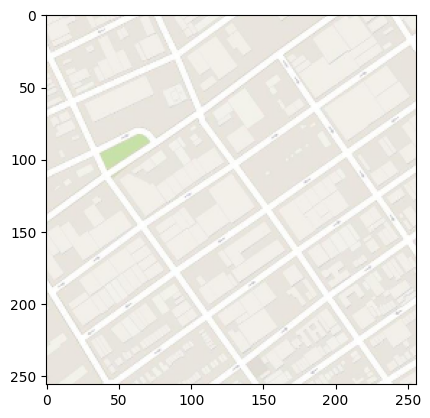

In [59]:
plt.imshow(((dataset[1][1].permute(2,1,0)) + 1) / 2)

In [60]:
device='cuda'
disc = Discriminator().to(device)
gen = Generator().to(device)
lr = 3e-3
opt_disc = torch.optim.Adam(disc.parameters(),lr=lr)
opt_gen = torch.optim.Adam(gen.parameters(),lr=lr)

criterion = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()
l1lambda = 100

loader = torch.utils.data.DataLoader(dataset,batch_size=5,shuffle=True)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()


In [61]:
from tqdm import tqdm

In [62]:
lr = 2e-4
loader = torch.utils.data.DataLoader(dataset,batch_size=30,shuffle=True)
opt_disc = torch.optim.Adam(disc.parameters(),lr=lr)
opt_gen = torch.optim.Adam(gen.parameters(),lr=lr)
num_epochs=51

for epoch in range(num_epochs+1):
    loop = tqdm(enumerate(loader),total = len(loader),leave=False)
    for batch_idx,(x,y) in loop:
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            d_real = disc(x,y)
            d_real_loss = criterion(d_real,torch.ones_like(d_real))
            d_fake = disc(x,y_fake.detach())
            d_fake_loss = criterion(d_fake,torch.zeros_like(d_fake))
            d_loss = (d_fake_loss + d_real_loss) / 2

        disc.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            d_fake = disc(x,y_fake)
            g_fake_loss = criterion(d_fake,torch.ones_like(d_fake))
            l1_penalty = l1(y_fake,y) * l1lambda
            g_loss = g_fake_loss + l1_penalty

        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        loop.set_description(f"Epoch : [{epoch}/{num_epochs}]")
        loop.set_postfix(d_loss=d_loss.mean().item(),g_loss=g_loss.mean().item())
        
    # if epoch % 1 == 0:
    #     print(f"Epoch {epoch} D_loss : {d_loss.mean()} G_loss : {g_loss.mean()}")
        # with torch.inference_mode():
        #     out =gen(dataset[0][0].to(device).unsqueeze(0))
        #     plt.imshow(out.cpu().squeeze(0).permute(1,2,0))

KeyboardInterrupt: 

In [66]:
lr = 2e-4
loader = torch.utils.data.DataLoader(dataset,batch_size=30,shuffle=True)
opt_disc = torch.optim.Adam(disc.parameters(),lr=lr)
opt_gen = torch.optim.Adam(gen.parameters(),lr=lr)
num_epochs=51

for epoch in range(num_epochs+1):
    loop = tqdm(enumerate(loader),total = len(loader),leave=False)
    for batch_idx,(x,y) in loop:
        x = x.to(device)
        y = y.to(device)

        
        y_fake = gen(x)
        d_real = disc(x,y)
        d_real_loss = criterion(d_real,torch.ones_like(d_real))
        d_fake = disc(x,y_fake.detach())
        d_fake_loss = criterion(d_fake,torch.zeros_like(d_fake))
        d_loss = (d_fake_loss + d_real_loss) / 2

        disc.zero_grad()
        d_loss.backward()
        opt_disc.step()

        with torch.cuda.amp.autocast():
            d_fake = disc(x,y_fake)
            g_fake_loss = criterion(d_fake,torch.ones_like(d_fake))
            l1_penalty = l1(y_fake,y) * l1lambda
            g_loss = g_fake_loss + l1_penalty

        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()

        loop.set_description(f"Epoch : [{epoch}/{num_epochs}]")
        loop.set_postfix(d_loss=d_loss.mean().item(),g_loss=g_loss.mean().item())
        
    # if epoch % 1 == 0:
    #     print(f"Epoch {epoch} D_loss : {d_loss.mean()} G_loss : {g_loss.mean()}")
        # with torch.inference_mode():
        #     out =gen(dataset[0][0].to(device).unsqueeze(0))
        #     plt.imshow(out.cpu().squeeze(0).permute(1,2,0))

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


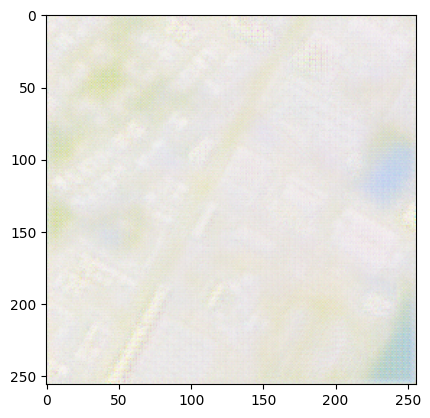

In [63]:
gen.eval()
with torch.inference_mode():
    out =(gen(dataset[35][0].to(device).unsqueeze(0)) * 0.5) + 0.5
gen.train()
plt.imshow(out.cpu().squeeze(0).permute(1,2,0))

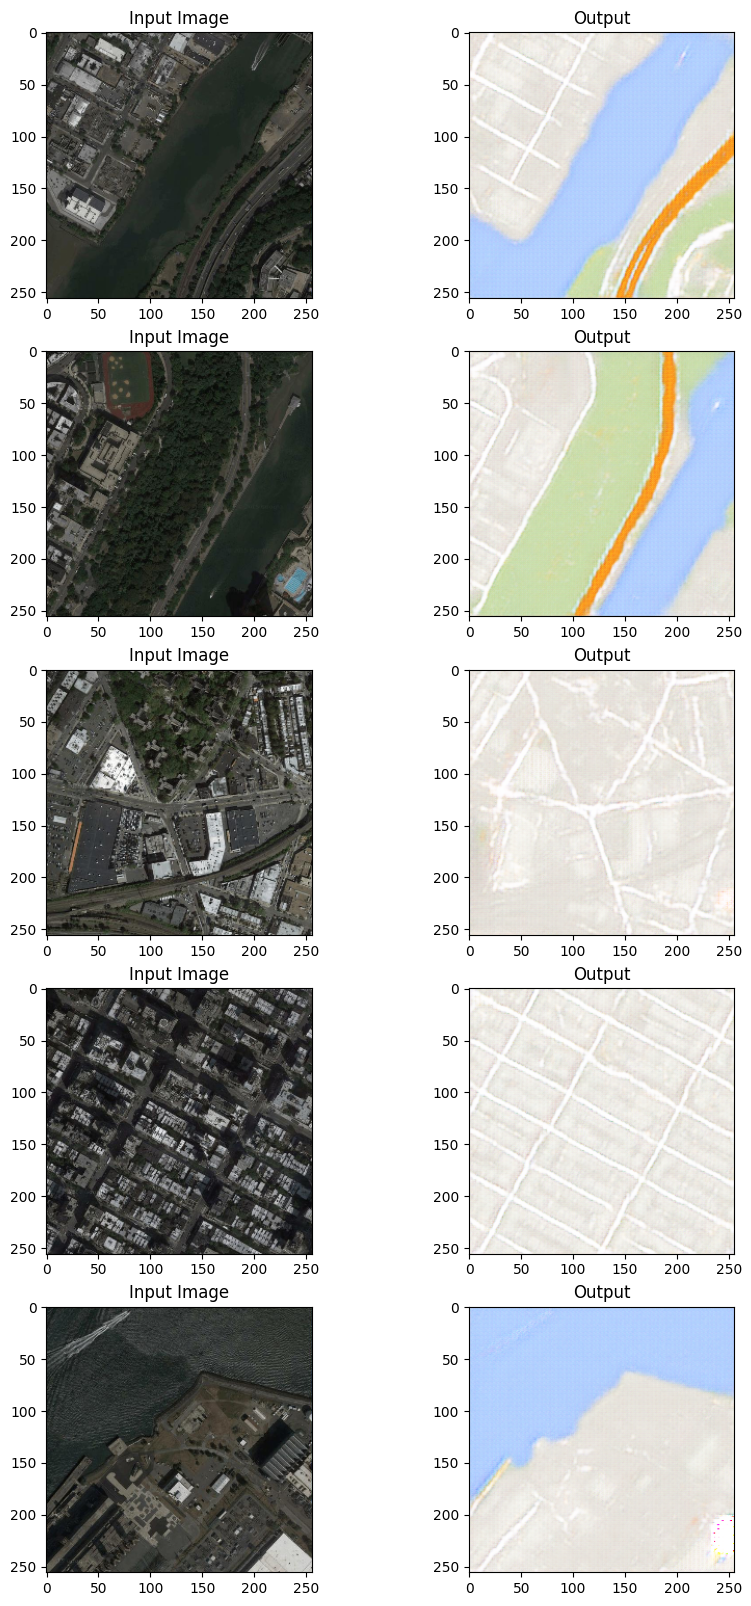

In [67]:
import random
device = 'cuda'
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    X,y = dataset[random.randint(1,50)]
    gen.eval()
    with torch.inference_mode():
        out =(gen(X.to(device).unsqueeze(0)) * 0.5) + 0.5
    gen.train()
    # Display input image with title
    axes[i][0].imshow((X.cpu().detach().squeeze(0).permute(1,2,0)+1)/2)
    axes[i][0].set_title('Input Image')

    # Display generated image with title
    axes[i][1].imshow(out.cpu().squeeze(0).permute(1,2,0))
    axes[i][1].set_title('Output')

# Hide axis ticks and labels for all subplots
    # for ax in axes:
    #     ax.axis('off')

In [48]:
gen = torch.load('mapgen.pth')

In [33]:
random.randint?

Signature: random.randint(a, b)
Docstring:
Return random integer in range [a, b], including both end points.
        
File:      c:\users\omalv\.conda\envs\pytorch\lib\random.py
Type:      method